# ASTR 519 Final Project: Cannon Dataset Mining

*by Nick Konz, Henry Gu, and Roark Habegger*

## 0. CSV Creation/Data Cleaning (Roark)

In [3]:
# some of the usual imports
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# files
file1 = "allStarCannon-l31c.2.fits"
file2 = "allStar-l31c.2.fits"

hdu_list = fits.open(file1)
abun_data = Table(hdu_list[1].data)

In [4]:
#This cell takes a while because the table takes up a lot of data
hdu_list2 = fits.open(file2)
vel_data = Table(hdu_list2[1].data)

In [5]:
cols = abun_data.colnames
myCols = []
myColNames = ["RA_HRS","DEC_DEG"]
for i in range(len(cols)):
    #Ditch all the raw errors
    if not ("RAW" in str(cols[i])):
        #Get all abundances
        if ("_H" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))
        #Get important non-abundance values that could be useful
        elif ("TEFF" in str(cols[i])) or ("LOGG" in str(cols[i])) or ("_M" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))

myColNames.append('RAD_VEL')
myColNames.append('RAD_VEL_ERR')
print(myColNames)

['RA_HRS', 'DEC_DEG', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'FE_H', 'C_H', 'CI_H', 'N_H', 'O_H', 'NA_H', 'MG_H', 'AL_H', 'SI_H', 'P_H', 'S_H', 'K_H', 'CA_H', 'TI_H', 'TIII_H', 'V_H', 'CR_H', 'MN_H', 'CO_H', 'NI_H', 'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR', 'FE_H_ERR', 'C_H_ERR', 'CI_H_ERR', 'N_H_ERR', 'O_H_ERR', 'NA_H_ERR', 'MG_H_ERR', 'AL_H_ERR', 'SI_H_ERR', 'P_H_ERR', 'S_H_ERR', 'K_H_ERR', 'CA_H_ERR', 'TI_H_ERR', 'TIII_H_ERR', 'V_H_ERR', 'CR_H_ERR', 'MN_H_ERR', 'CO_H_ERR', 'NI_H_ERR', 'RAD_VEL', 'RAD_VEL_ERR']


In [6]:
#Ditch entries without data
ii = (abun_data['FILENAME'] != '')

print(len(abun_data['APOGEE_ID']))
print(len(abun_data['APOGEE_ID'][ii]))
print(len(abun_data['APOGEE_ID'][ii])/len(abun_data['APOGEE_ID']))

#can parse ratios by error

277371
164074
0.5915326403985998


In [24]:
#Make array of current vals
myArr = np.array(abun_data[:][ii])
newArr = np.zeros([len(abun_data[:][ii]),len(myCols)+4],)
print(len(myArr))
print(newArr.shape)
locArr = np.array(vel_data['APOGEE_ID'][1:])
radArr = np.array(vel_data['VHELIO_AVG'][1:])
radErrArr = np.array(vel_data['VERR'][1:])

164074
(164074, 52)


In [25]:
i=0
l1=0

for i in range(len(myArr)):
    myrow = myArr[i]
    
    #Parse RA
    locStr = myrow[0]
    raStr = locStr[2:10]
    hrs = int(raStr[0:2])
    mins = int(raStr[2:4])
    secs = int(raStr[4:6])+ int(raStr[6:8])/100.0
    ra = hrs+mins/60.0+secs/3600.0

    #Parse Dec
    decStr = locStr[10:]
    if decStr[0] == "+":
        decSgn = 1.0
    else:
        decSgn = -1.0
    deg = int(decStr[1:3])*decSgn
    arcMins = int(decStr[3:5])*decSgn
    arcSecs = (int(decStr[5:7])+int(decStr[7])/10.0)*decSgn
    dec = deg+arcMins/60.0+arcSecs/3600.0


    #Save RA and Dec
    newArr[i,:2] = [ra,dec]

    ##Get Rad velocity
    ind = -1
    for l in range(l1,len(locArr)):
        if locArr[l]  == locStr:
            ind = l
            l1 = l
            break
    newArr[i,-2] = radArr[ind]
    newArr[i,-1]= radErrArr[ind]

    #Save Abundance Values
    k=0
    for j in myCols:
        colNom = myColNames[2+k]
        val=0.0
        #IF the value is bad, replace with a NaN to take up less data
        if (colNom == "NA_H_ERR"):
            valInd = 2+k-24
            if (newArr[i,valInd]<=-100.0):
                newArr[i,valInd] = np.nan
                val=np.nan
            else:
                val=myrow[j]

        if ("_ERR" in colNom) and (myrow[j] >=1) and not ("TEFF" in colNom):
            val = np.nan
            valInd = 2+k-24
            newArr[i,valInd]=np.nan

        else:
            val = myrow[j]

        newArr[i,2+k] = val
        k+=1
    perc = i/len(myArr)
    
    #Sometimes print out the fraction of data we have parsed and organized
    if int(i/20000.0) == i/20000.0:
        print(perc)



0.0
0.1218962175603691
0.2437924351207382
0.3656886526811073
0.4875848702414764
0.6094810878018455
0.7313773053622146
0.8532735229225837
0.9751697404829528


In [26]:
#Save the File to Cannon.csv with proper header
saveFile = "Cannon.csv"
headStr = ""
for entry in myColNames:
    headStr += entry
    headStr += ','
np.savetxt(saveFile,newArr,delimiter=',',fmt="%1.8e",header=headStr[:-1],comments='')

In [27]:
# Plot velocities vs. equitorial coordinates:
myArr = np.loadtxt(saveFile,delimiter=',',skiprows=1)
headArr = np.loadtxt(saveFile,delimiter=',',max_rows=1,dtype=str)
data = {}
for i in range(len(headArr)):
    data[headArr[i]] = myArr[:,i]


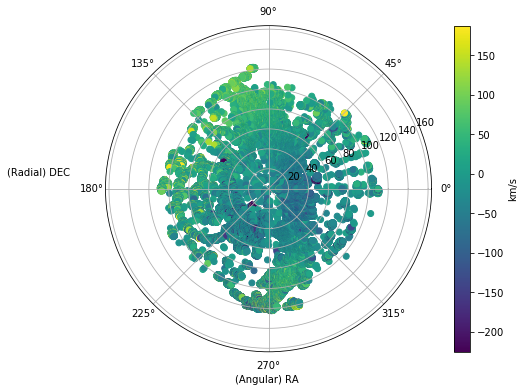

In [28]:
maxVel = np.max(np.abs(data['RAD_VEL']))

scaledVel = data['RAD_VEL']/maxVel
#plt.figure(1)
#plt.hist(scaledVel,range=[-0.24,0.2],bins=100)

th = data['RA_HRS']*2*np.pi/24.0
rad = -data['DEC_DEG']+90

fig = plt.figure(2,figsize=[8,6])
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(th, rad, c=data['RAD_VEL'], cmap='viridis',vmin=-0.24*maxVel,vmax=0.2*maxVel)

#c.colorbar(label='km/s')
ax.set_xlabel("(Angular) RA ")
ax.set_ylabel("(Radial) DEC          \n        ",rotation=0,ha='right')
fig.colorbar(c,label='km/s')
plt.show()

## 2. K-Means (Henry)

*(Henry's code/plots go here)*

## 3. GMMs and UMAP (Nick)

In [15]:
# IMPORTS
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
import umap

In [29]:
# READ IN DATA
master_filename = "Cannon.csv"

master_df = pd.read_csv(master_filename)
master_df = master_df.drop(columns=[master_df.columns[-1]]) # get rid of last column of NaNs
master_df = master_df.drop(columns=[col for col in master_df.columns if "ERR" in col])# get rid of err columns (don't care about these)
# get rid of rows with NaNs
master_df = master_df.dropna()

print(master_df.columns)
master_df

Index(['RA_HRS', 'DEC_DEG', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'FE_H', 'C_H',
       'CI_H', 'N_H', 'O_H', 'NA_H', 'MG_H', 'AL_H', 'SI_H', 'P_H', 'S_H',
       'K_H', 'CA_H', 'TI_H', 'TIII_H', 'V_H', 'CR_H', 'MN_H', 'CO_H', 'NI_H',
       'RAD_VEL'],
      dtype='object')


,RA_HRS,DEC_DEG,TEFF,LOGG,M_H,ALPHA_M,FE_H,C_H,CI_H,N_H,...,K_H,CA_H,TI_H,TIII_H,V_H,CR_H,MN_H,CO_H,NI_H,RAD_VEL
0,0.000006,74.285389,3727.69779,0.531083,-0.075315,-0.001618,-0.095524,-0.131261,-0.136875,0.175975,...,-0.008325,0.105255,0.125092,0.041956,0.286820,-0.098360,-0.024909,-0.102881,-0.082262,-52.168999
1,0.000189,57.173139,5009.32634,3.328694,-0.111417,-0.001791,-0.116588,-0.204118,-0.224102,-0.030289,...,-0.186456,-0.170949,-0.069751,-0.482286,-0.155060,-0.111359,-0.136346,-1.212067,-0.146827,-12.169000
2,0.000586,63.463056,4657.17842,2.245739,0.026965,-0.013804,0.053893,-0.195703,-0.268514,0.495446,...,-0.040017,0.074190,0.462857,-0.060474,0.232002,0.019163,-0.018021,-0.284968,0.037063,-107.014000
4,0.000881,58.360639,3890.75048,0.857215,-0.178921,0.050077,-0.175300,-0.163705,-0.193516,0.160349,...,-0.044356,-0.128825,-0.171811,-0.075015,-0.128707,-0.129677,-0.175031,-0.114216,-0.161474,-80.212196
5,0.001239,58.909139,4747.95337,2.377376,-0.001440,-0.025889,0.000664,-0.181968,-0.321754,0.394059,...,0.142464,0.065730,0.039681,-0.023183,-0.043220,-0.038862,-0.025839,-0.041874,-0.002938,-47.995701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164066,23.998717,64.715583,4068.17983,1.063511,-0.476503,-0.021310,-0.479274,-0.584773,-0.615526,-0.196308,...,-0.578180,-0.473753,-0.626153,-0.285346,-0.719176,-0.418621,-0.559894,-0.423542,-0.456180,-47.169701
164067,23.998750,64.049222,4342.72311,1.814609,-0.176498,0.016720,-0.172619,-0.250403,-0.233407,0.056770,...,0.010530,-0.084628,-0.192880,0.476949,-0.414757,-0.147386,-0.185848,-0.069345,-0.141608,-127.753998
164068,23.998758,63.650556,5044.91507,2.831689,0.137040,-0.056630,0.148526,-0.045335,-0.074057,0.595031,...,-0.231088,0.135896,0.421992,0.299644,0.015207,0.447611,0.135198,-0.103953,0.127918,-69.385803
164069,23.998906,62.853361,4303.95700,1.826523,-0.013265,0.004226,-0.000182,-0.081725,-0.152445,0.271401,...,0.351427,0.061267,-0.105833,0.028881,-0.079537,0.010550,-0.032423,0.158870,0.030211,-58.560001


### 3.1 GMMs

*Fig. 3.1.1*

Analyzing CA_H vs N_H...


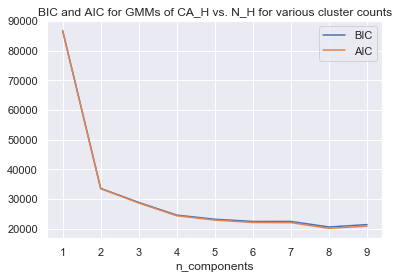

optimal n_components = 2


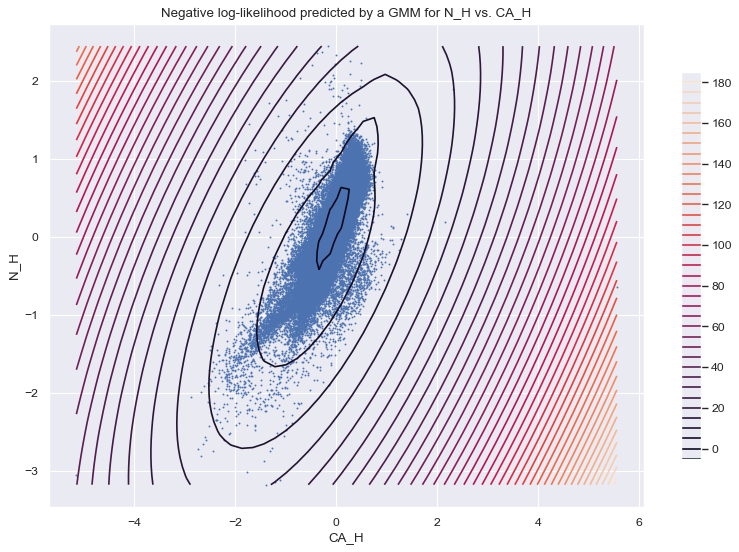

In [38]:
# Here, I tried to determine correlations or clustering between individual parameters
# Don't actually run this for everything; it will take forever
# I just have it run for a single set, as an example
example_params = ["CA_H", "N_H"]

for col1 in master_df.columns:
    for col2 in master_df.columns:
        if col1 != col2 and col1 == example_params[0] and col2 == example_params[1]:
            print("Analyzing {} vs {}...".format(col1, col2))

            u = np.column_stack([master_df[col1], master_df[col2]])

#             print(u.shape)

            n_estimators = np.arange(1, 10)
            clfs = [GaussianMixture(n_components=n, covariance_type='full').fit(u) for n in n_estimators]
            bics = [clf.bic(u) for clf in clfs]
            aics = [clf.aic(u) for clf in clfs]

            plt.plot(n_estimators, bics, label='BIC')
            plt.plot(n_estimators, aics, label='AIC')
            plt.title("BIC and AIC for GMMs of {} vs. {} for various cluster counts".format(col1, col2))
            plt.xlabel("n_components")
            plt.legend()
            plt.show()

            best_n = np.argmax(bics[1:]) + 2

            print("optimal n_components = {}".format(best_n))


            clf = GaussianMixture(n_components=best_n, covariance_type='full')
            clf.fit(u)

            # display predicted scores by the model as a contour plot
            x = np.linspace(np.min(u[:,0]), np.max(u[:,0]))
            y = np.linspace(np.min(u[:,1]), np.max(u[:,1]))
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)

            plt.figure(figsize=(12,8), dpi=80)
            CS = plt.contour(X, Y, Z, levels=42)
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(u[:,0], u[:,1], s=0.5)

            plt.title('Negative log-likelihood predicted by a GMM for {} vs. {}'.format(col2, col1))
            plt.axis('tight')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.show()

Analyzing Correlation of N_H vs. CA_H:


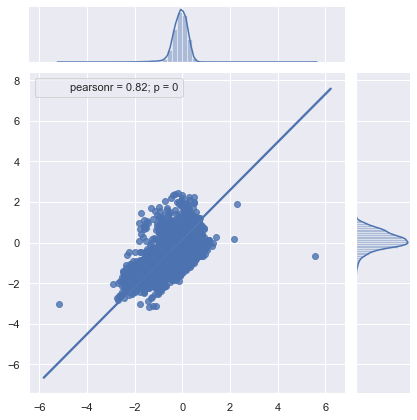

In [32]:
# Also attempted something similar with seaborn linear correlation plotting,
# again with all possible 2-combinations (again excluded here for brevity)
import scipy.stats as stats
import warnings  
warnings.filterwarnings('ignore')
import seaborn as sns

for col1 in master_df.columns:
    for col2 in master_df.columns:
        if col1 != col2 and col1 == example_params[0] and col2 == example_params[1]:
            u = np.column_stack([master_df[col1], master_df[col2]])
            
            print("Analyzing Correlation of {} vs. {}:".format(col2, col1))
            sns.set(style="darkgrid", color_codes=True)
            g = sns.jointplot(u[:,0], u[:,1], kind="reg")
            g.annotate(stats.pearsonr)
            plt.show()

*Fig. 3.1.2*

In [33]:
# create high-dimensional datasets for (excluding effective temperature, surface gravity,
# and overall abundance measurements as we didn't think they'd be relavant):

badcols_ab_pos = ["TEFF", "LOGG", "M_H", "ALPHA_M", 'RAD_VEL']  # abundances + equitorial positions
badcols_ab_vel = ["TEFF", "LOGG", "M_H", "ALPHA_M", 'RA_HRS', 'DEC_DEG'] # abundances + velocity
badcols_ab_phase = ["TEFF", "LOGG", "M_H", "ALPHA_M"] # abundances + positions + velocity

ab_pos_df = master_df.drop(columns=[col for col in master_df.columns if col in badcols_ab_pos])# get rid of err columns (don't care about these)
ab_vel_df = master_df.drop(columns=[col for col in master_df.columns if col in badcols_ab_vel])# get rid of err columns (don't care about these)
ab_phase_df = master_df.drop(columns=[col for col in master_df.columns if col in badcols_ab_phase])# get rid of err columns (don't care about these)

# get rid of rows with NaNs
ab_pos_df = ab_pos_df.dropna()
ab_vel_df = ab_vel_df.dropna()
ab_phase_df = ab_phase_df.dropna()

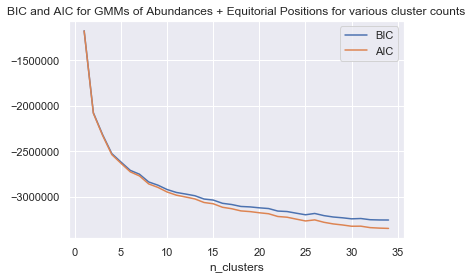

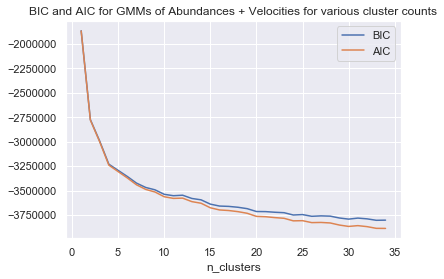

In [ ]:
# Run GMMs over 1 - 35 clusters on the above three datasets
# THESE TAKE A WHILE, so we included imgs of the outputs below.

max_clusters = 35
names = {"ab_pos_df": "Abundances + Equitorial Positions",
        "ab_vel_df": "Abundances + Velocities",
         "ab_phase_df": "Abundances + Equitorial Positions + Velocities"
        }
dfs = {"ab_pos_df": ab_pos_df,
        "ab_vel_df": ab_vel_df,
         "ab_phase_df": ab_phase_df
        }

for k in dfs:
    u = dfs[k]
    n_estimators = np.arange(1, max_clusters)
    clfs = [GaussianMixture(n_components=n, covariance_type='full').fit(u) for n in n_estimators]
    bics = [clf.bic(u) for clf in clfs]
    aics = [clf.aic(u) for clf in clfs]

    plt.title("BIC and AIC for GMMs of {} for various cluster counts".format(names[k]))
    plt.plot(n_estimators, bics, label='BIC')
    plt.plot(n_estimators, aics, label='AIC')
    plt.xlabel("n_clusters")
    plt.legend()
    plt.show()

*Outputs:*

**1. Abundances + Equitorial Positions:**

<div class="container"; width:10px; margin:0 auto;>
<IMG SRC='bic_ab_pos.png' ALIGN='left'/> <br>
</div>

**2. Abundances + Velocities:**

<div class="container"; width:10px; margin:0 auto;>
<IMG SRC='bic_ab_vel.png' ALIGN='left'/> <br>
</div>

**3. Abundances + Equitorial Positions + Velocities:**

<div class="container"; width:10px; margin:0 auto;>
<IMG SRC='bic_ab_phase.png' ALIGN='left'/> <br>
</div>

### 3.2 UMAP

*Fig. 3.2.1*

In [41]:
# First, we simply ran UMAP on the entire dataset,
# with parameters that are best for clustering (creating overall structure):
# We then ran a GMM on this to attempt to see any 
# Again, this takes a while to run, so we've included the output below
fit = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2)
%time um = fit.fit_transform(master_df)

CPU times: user 6min 53s, sys: 12.9 s, total: 7min 6s
Wall time: 2min 20s


Text(0.5, 1.0, 'UMAP embedding of entire Cannon dataset')

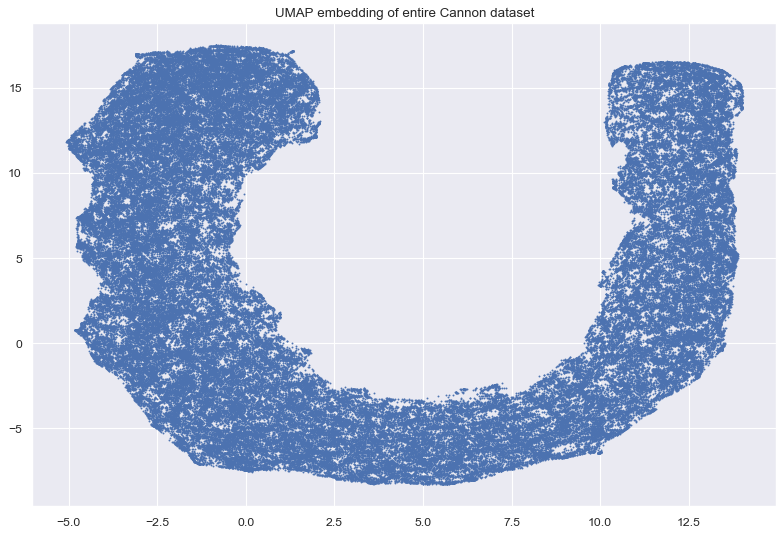

In [42]:
plt.figure(figsize=(12,8), dpi=80)
plt.scatter(um[:,0], um[:,1], s=0.5)
plt.title('UMAP embedding of entire Cannon dataset')

*Output example (note that actual output shape is fairly random, although number of clusters generally isn't):*

<div class="container"; width:10px; margin:0 auto;>
<IMG SRC='masterdf_umap.png' ALIGN='left'/> <br>
</div>

*Fig. 3.2.2:*

In [ ]:
# We then attempted the same, but on the same three datasets that the 
# GMM analysis was performed on
for k in dfs:
    df = dfs[k]
    fit = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2)
    %time u = fit.fit_transform(df)
    
    plt.figure(figsize=(12,8), dpi=80)
    plt.scatter(u[:,0], u[:,1], s=0.5)
    plt.title('UMAP embedding of {} dataset'.format(names[k]))

## 4. DBSCAN (Roark)

*(Roark's code/plots go here)*